In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pyspark
from pyspark.sql.functions import col, udf,sum, desc,asc,when,regexp_replace,count_distinct
from pyspark.sql.types import DateType
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *
pd.get_option("display.max_columns")
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Sales2').getOrCreate()
spark

In [4]:
df = spark.read.csv('SuperStoreSales.csv', inferSchema = True, header=True)
df.show()

+------+--------------+----------+----------+--------------+-----------+------------------+-----------+-------------+---------------+--------------+-----------+-------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|Row ID|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|     Customer Name|    Segment|      Country|           City|         State|Postal Code| Region|     Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|
+------+--------------+----------+----------+--------------+-----------+------------------+-----------+-------------+---------------+--------------+-----------+-------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|     1|CA-2016-152156| 11/8/2016|11/11/2016|  Second Class|   CG-12520|       Claire Gute|   Consumer|United States|      Henderson|      Kentucky|      42420|  South|FUR-BO-10001798|   

# Preprocess

## Renaming Columns

In [5]:
df = df.withColumnRenamed('Order ID',
                          'OrderID').withColumnRenamed('Customer ID',
                                                       'CustomerID').withColumnRenamed('Customer Name',
                                                                                      'CustomerName').withColumnRenamed('Product ID',
                                                                                                                       'ProductID').withColumnRenamed('Postal Code', 'PostalCode')
df = df.withColumnRenamed('Product Name',
                          'ProductName').withColumnRenamed('Regional Manager',
                                                       'RegionalManager').withColumnRenamed('Customer Name',
                                                                                      'CustomerName').withColumnRenamed('Sub-Category',
                                                                                                                       'SubCategory').withColumnRenamed('Country/Region',
                                                                                                                       'Country_Region').withColumnRenamed('State/Province',
                                                                                                                       'State_Province')
df = df.withColumnRenamed('Order Date',
                          'OrderDate').withColumnRenamed('Ship Date',
                                                       'ShipDate').withColumnRenamed('Ship Mode',
                                                                                      'ShipMode')

## Converting Variables to correct datatype

In [ ]:
func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())
df = df.withColumn('OrderDate', func(col("OrderDate")))
df = df.withColumn('ShipDate', func(col("ShipDate")))

## Normalizing database 

In [6]:
df.createOrReplaceTempView("Sales")

Furniture_DF = spark.sql("SELECT * FROM Sales Where Sales.Category = 'Furniture'")
#Furniture_DF.show()

In [137]:
Furniture_DF.printSchema()

root
 |-- Row ID: integer (nullable = true)
 |-- OrderID: string (nullable = true)
 |-- OrderDate: string (nullable = true)
 |-- ShipDate: string (nullable = true)
 |-- ShipMode: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- CustomerName: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- PostalCode: integer (nullable = true)
 |-- Region: string (nullable = true)
 |-- ProductID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- SubCategory: string (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Profit: double (nullable = true)



In [12]:
df.createOrReplaceTempView("normalize")

Order_df = spark.sql("SELECT distinct OrderID,CustomerID,OrderDate,ShipDate,ShipMode FROM normalize")
customer_df = spark.sql("SELECT distinct CustomerID,CustomerName,PostalCode  FROM normalize")
Area_df = spark.sql("SELECT distinct PostalCode,Region,Country,State,City  FROM normalize")
Product_df = spark.sql("SELECT distinct ProductID,ProductName,Segment  FROM normalize")
main_df = spark.sql("SELECT distinct OrderID,ProductID,Sales,Quantity,Discount,Profit  FROM normalize")

In [13]:
Order_df.show()

+--------------+----------+----------+----------+--------------+
|       OrderID|CustomerID| OrderDate|  ShipDate|      ShipMode|
+--------------+----------+----------+----------+--------------+
|CA-2015-134894|  DK-12985| 12/7/2015|12/11/2015|Standard Class|
|CA-2017-126046|  JC-16105| 11/3/2017| 11/7/2017|Standard Class|
|US-2015-140200|  CA-12775| 7/26/2015| 7/28/2015|   First Class|
|US-2016-144393|  SM-20950|10/28/2016| 11/4/2016|Standard Class|
|US-2015-161466|  ON-18715| 9/24/2015| 9/27/2015|  Second Class|
|CA-2016-100965|  RM-19375|  7/7/2016| 7/11/2016|Standard Class|
|CA-2015-129854|  RB-19705| 8/22/2015| 8/26/2015|Standard Class|
|CA-2016-165848|  EN-13780|  6/4/2016|  6/4/2016|      Same Day|
|CA-2016-147368|  TC-21295|  6/9/2016| 6/12/2016|   First Class|
|CA-2017-102099|  EP-13915|12/18/2017|12/19/2017|   First Class|
|CA-2014-108189|  ES-14080| 10/2/2014| 10/5/2014|   First Class|
|CA-2016-137176|  DB-12910|  9/9/2016| 9/14/2016|  Second Class|
|CA-2016-104157|  MT-1781

In [14]:
customer_df.show()

+----------+------------------+----------+
|CustomerID|      CustomerName|PostalCode|
+----------+------------------+----------+
|  JD-15895|  Jonathan Doherty|     19140|
|  AR-10510|    Andrew Roberts|     90004|
|  GT-14710|         Greg Tran|     55044|
|  TD-20995|     Tamara Dahlen|     97206|
|  SC-20770|Stewart Carmichael|     75081|
|  JO-15280|     Jas O'Carroll|     59801|
|  RB-19435|   Richard Bierner|     63116|
|  CT-11995|      Carol Triggs|     46203|
|  FM-14215|     Filia McAdams|      6457|
|  CC-12220|      Chris Cortes|      6824|
|  LR-16915|      Lena Radford|     90045|
|  BT-11680|    Brian Thompson|     20735|
|  SN-20710|      Steve Nguyen|     77506|
|  AW-10930|   Arthur Wiediger|     94110|
|  BD-11500|   Bradley Drucker|     94122|
|  RB-19435|   Richard Bierner|     22153|
|  BE-11455|        Brad Eason|     50315|
|  BF-10975|    Barbara Fisher|     30076|
|  MS-17710|     Maurice Satty|     93727|
|  DB-12910|       Daniel Byrd|     92630|
+----------

In [15]:
Area_df.show()

+----------+-------+-------------+--------------+-----------+
|PostalCode| Region|      Country|         State|       City|
+----------+-------+-------------+--------------+-----------+
|     60090|Central|United States|      Illinois|   Wheeling|
|     98208|   West|United States|    Washington|    Everett|
|     28027|  South|United States|North Carolina|    Concord|
|     92563|   West|United States|    California|   Murrieta|
|     70506|  South|United States|     Louisiana|  Lafayette|
|     77536|Central|United States|         Texas|  Deer Park|
|     91505|   West|United States|    California|    Burbank|
|     87105|   West|United States|    New Mexico|Albuquerque|
|     99301|   West|United States|    Washington|      Pasco|
|     77705|Central|United States|         Texas|   Beaumont|
|     35630|  South|United States|       Alabama|   Florence|
|     85364|   West|United States|       Arizona|       Yuma|
|     84043|   West|United States|          Utah|       Lehi|
|     98

In [16]:
Product_df.show()

+---------------+--------------------+-----------+
|      ProductID|         ProductName|    Segment|
+---------------+--------------------+-----------+
|TEC-PH-10004536|Avaya 5420 Digita...|   Consumer|
|FUR-CH-10004287|SAFCO Arco Foldin...|   Consumer|
|TEC-PH-10003273|        AT&T TR1909W|Home Office|
|FUR-FU-10004712|Westinghouse Mesh...|  Corporate|
|FUR-BO-10004409|Safco Value Mate ...|   Consumer|
|OFF-LA-10004272|           Avery 482|  Corporate|
|OFF-AR-10001988|Bulldog Table or ...|  Corporate|
|OFF-ST-10001321|Decoflex Hanging ...|  Corporate|
|OFF-BI-10000320|GBC Plastic Bindi...|   Consumer|
|OFF-EN-10002230|   Airmail Envelopes|Home Office|
|OFF-PA-10000349|   Easy-staple paper|   Consumer|
|OFF-AR-10002135|Boston Heavy-Duty...|   Consumer|
|OFF-BI-10001072|GBC Clear Cover  ...|  Corporate|
|OFF-BI-10000831|Storex Flexible P...|Home Office|
|FUR-TA-10004767|Safco Drafting Table|  Corporate|
|OFF-AR-10001770|  Economy #2 Pencils|   Consumer|
|OFF-PA-10002713|Adams Phone Me

In [17]:
main_df.show()

+--------------+---------------+-------+--------+--------+---------+
|       OrderID|      ProductID|  Sales|Quantity|Discount|   Profit|
+--------------+---------------+-------+--------+--------+---------+
|US-2015-150630|OFF-AR-10004042| 86.304|       6|     0.2|   9.7092|
|CA-2017-106180|OFF-EN-10004030|  10.86|       3|     0.0|   5.1042|
|US-2017-145366|OFF-EN-10004386| 57.576|       3|     0.2|   21.591|
|CA-2016-103891|TEC-PH-10000149|  95.76|       6|     0.2|    7.182|
|CA-2017-104220|OFF-BI-10000301|  32.35|       5|     0.0|   16.175|
|US-2017-132444|OFF-BI-10001116|  8.448|       2|     0.2|   2.9568|
|CA-2014-118976|OFF-BI-10001628|  20.86|       2|     0.0|    9.387|
|CA-2016-121034|OFF-FA-10000585| 11.168|       4|     0.2|   3.6296|
|CA-2014-164721|OFF-AP-10000240| 320.88|       6|     0.0|  93.0552|
|CA-2015-117961|OFF-BI-10003707|  61.04|       4|     0.0|    30.52|
|CA-2017-157931|FUR-CH-10000785| 723.92|       4|     0.0| 188.2192|
|US-2014-155502|TEC-PH-10004833| 1

## Checking for null values

In [ ]:
from pyspark.sql import functions as F
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

In [ ]:
df = df.drop('Row ID')
df.show()

# EDA

In [21]:
df = df.toPandas()

In [22]:
df.head()

,Row ID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,Hon Deluxe Fabric Upholstered Stacking Chairs ...,731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


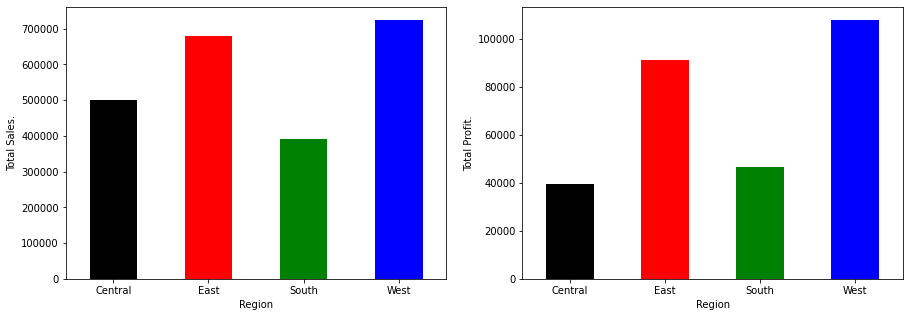

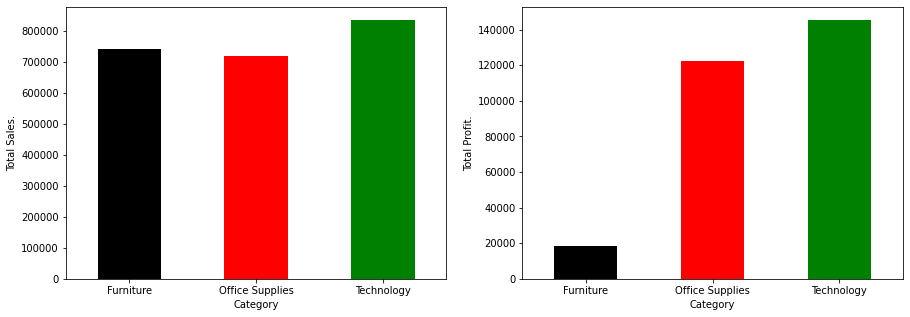

In [70]:
Categorical_Variables = ['Sales','Profit']
def plot_variable(Grouping_Variable):
    plt.figure(figsize=(15,5))
    a = 1
    b = 2
    c = 1

    for feature in Categorical_Variables:
        plt.subplot(a,b,c)
        df.groupby(Grouping_Variable)[feature].sum().plot.bar(color=['black', 'red', 'green', 'blue'])
        plt.ylabel(f"Total {feature}.")
        plt.xlabel(Grouping_Variable)
        plt.xticks(rotation=0)
        c=c+1

    return plt.show()

plot_variable('Region')
plot_variable('Category')

Text(0, 0.5, 'Total number of customers')

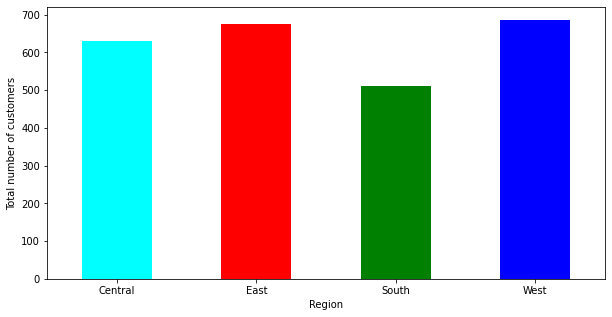

In [71]:
plt.figure(figsize=(10,5))
pandasDF.groupby('Region')['CustomerID'].nunique().plot.bar(color=['cyan', 'red', 'green', 'blue'])
plt.xticks(rotation=0)
plt.xlabel('Region')
plt.ylabel('Total number of customers')

Text(0, 0.5, 'Sales')

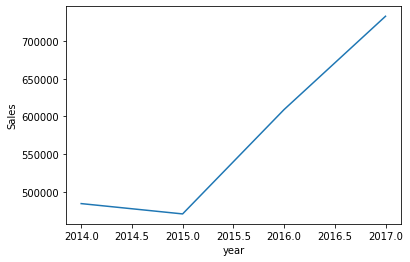

In [74]:
dateGrouped = pandasDF.groupby('OrderDate',as_index = False)['Sales','Profit','Quantity'].sum()
dateGrouped["OrderDate"] = pd.to_datetime(dateGrouped["OrderDate"],infer_datetime_format=True )
dateGrouped['month_year'] = dateGrouped['OrderDate'].dt.to_period('M')
dateGrouped['year'] = dateGrouped['OrderDate'].dt.year
dateGrouped['month'] = dateGrouped['OrderDate'].dt.month_name()
dateGrouped.groupby('year')['Sales'].sum().plot()
plt.ylabel('Sales')

In [83]:
dateGrouped.head()

,OrderDate,Sales,Profit,Quantity,month_year,year,month
0,2017-01-01,1481.828,-181.4109,56,2017-01,2017,January
1,2014-01-10,54.830,22.6537,2,2014-01,2014,January
2,2015-01-10,1018.104,-373.3048,4,2015-01,2015,January
3,2016-01-10,174.750,55.3653,11,2016-01,2016,January
4,2014-01-11,9.940,3.0814,2,2014-01,2014,January


In [80]:
# Set the default text font size


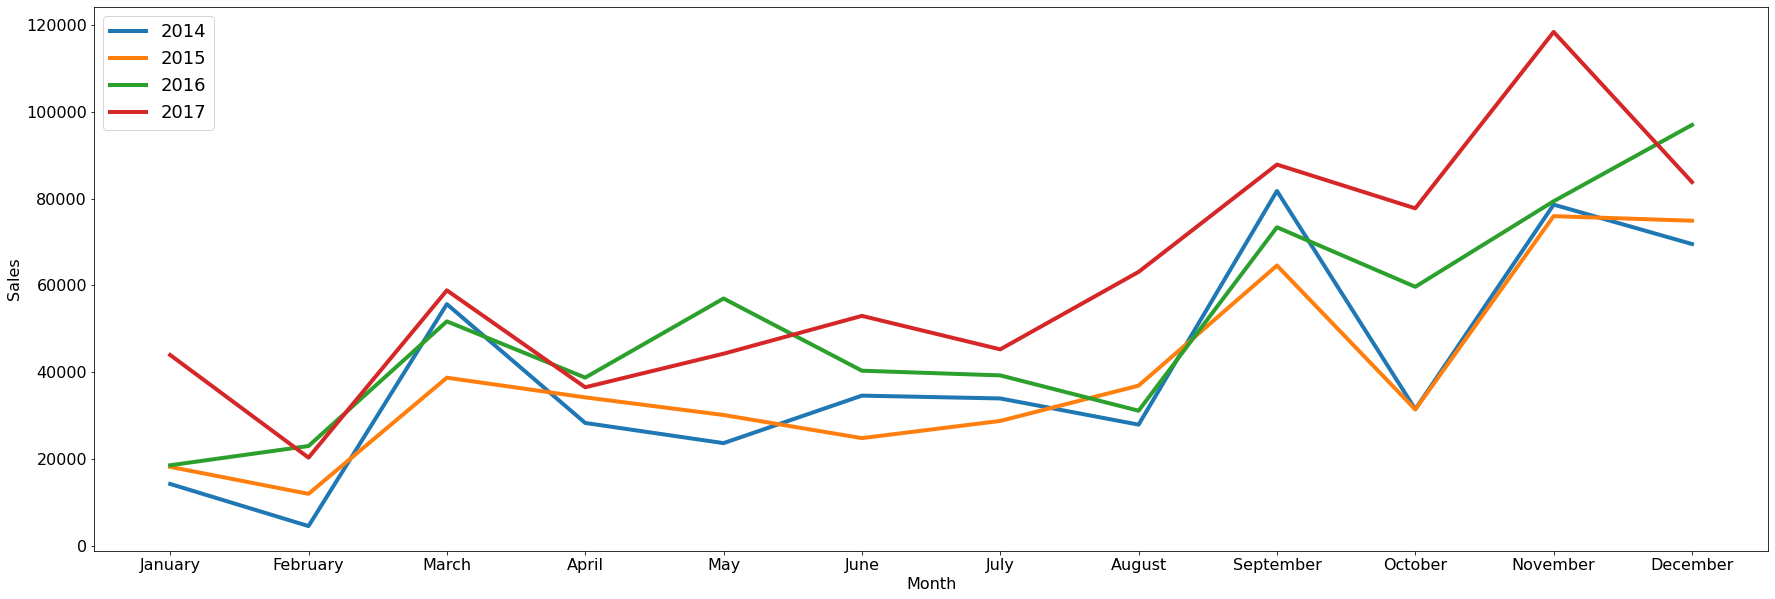

Text(0, 0.5, 'Profit')

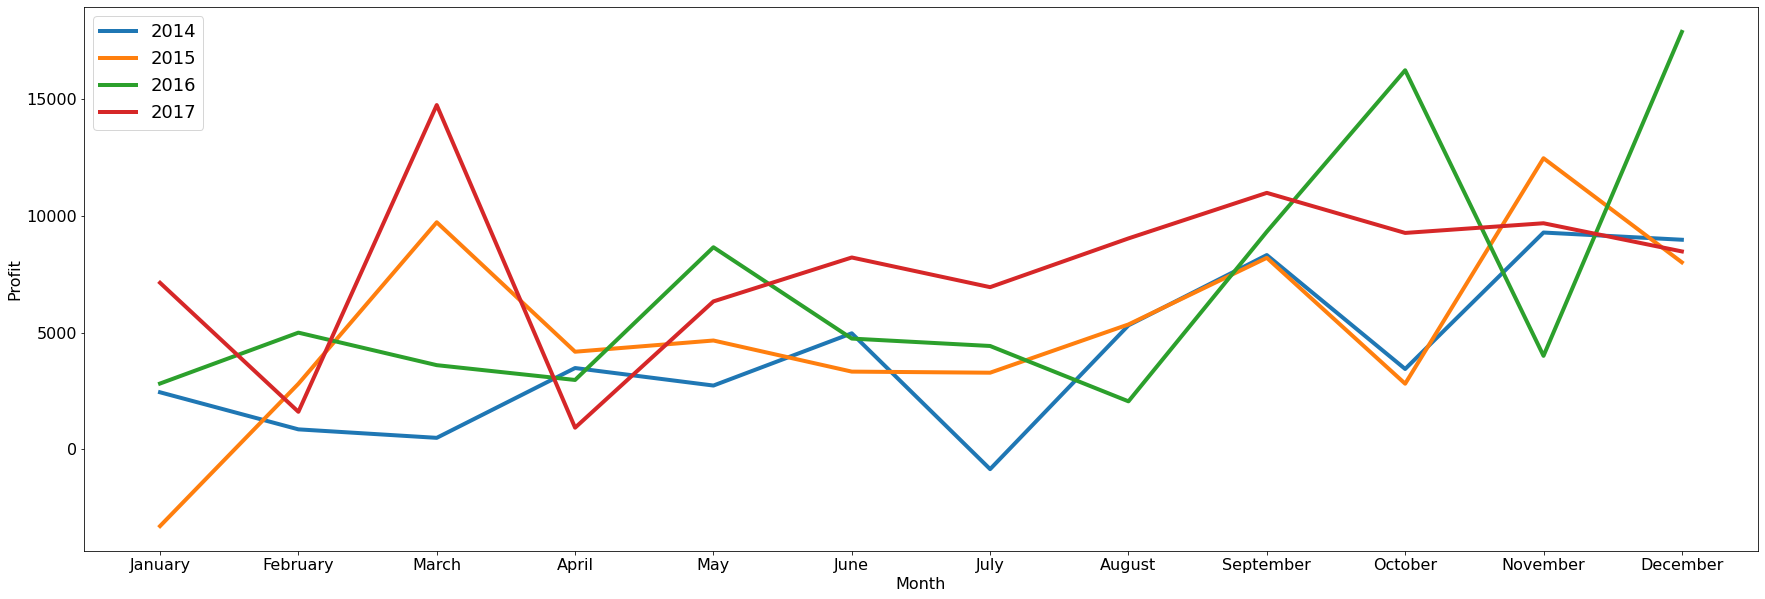

In [138]:
plt.rc('font', size=16)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=16)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=16)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=16)
# Set the legend font size
plt.rc('legend', fontsize=18)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

df_2014 = dateGrouped[dateGrouped['year']==2014][['month','Sales','Profit','Quantity']]
df_2014 = df_2014.groupby('month').agg({"Sales" : "sum","Profit": "sum","Quantity":"sum"}).reset_index().rename(columns={'sales':'s13'})
df_2014= Sort_Dataframeby_Month(df=df_2014,monthcolumnname='month')
df_2015 = dateGrouped[dateGrouped['year']==2015][['month','Sales','Profit','Quantity']]
df_2015 = df_2015.groupby('month').agg({"Sales" : "sum","Profit": "sum","Quantity":"sum"}).reset_index().rename(columns={'sales':'s13'})
df_2015= Sort_Dataframeby_Month(df=df_2015,monthcolumnname='month')
df_2016 = dateGrouped[dateGrouped['year']==2016][['month','Sales','Profit','Quantity']]
df_2016 = df_2016.groupby('month').agg({"Sales" : "sum","Profit": "sum","Quantity":"sum"}).reset_index().rename(columns={'sales':'s13'})
df_2016= Sort_Dataframeby_Month(df=df_2016,monthcolumnname='month')
df_2017 = dateGrouped[dateGrouped['year']==2017][['month','Sales','Profit','Quantity']]
df_2017 = df_2017.groupby('month').agg({"Sales" : "sum","Profit": "sum","Quantity":"sum"}).reset_index().rename(columns={'sales':'s13'})
df_2017= Sort_Dataframeby_Month(df=df_2017,monthcolumnname='month')

plt.figure(figsize=(30,10))
plt.plot(df_2014.month, df_2014.Sales,label = '2014', linewidth=4)
plt.plot(df_2015.month, df_2015.Sales, label = '2015',linewidth=4)
plt.plot(df_2016.month, df_2016.Sales,label = '2016',linewidth=4)
plt.plot(df_2017.month, df_2017.Sales, label = '2017', linewidth=4)
plt.legend()
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

plt.figure(figsize=(30,10))
plt.plot(df_2014.month, df_2014.Profit,label = '2014', linewidth=4)
plt.plot(df_2015.month, df_2015.Profit, label = '2015',linewidth=4)
plt.plot(df_2016.month, df_2016.Profit,label = '2016',linewidth=4)
plt.plot(df_2017.month, df_2017.Profit, label = '2017', linewidth=4)
plt.legend()
plt.xlabel('Month')
plt.ylabel('Profit')

In [87]:
sales_df = df[['OrderDate','Sales']]
sales_df["OrderDate"] = pd.to_datetime(sales_df["OrderDate"])
sales_df = sales_df.sort_values('OrderDate')
sales_df = sales_df.groupby('OrderDate',as_index = False)['Sales'].sum()
sales_df = sales_df.groupby([pd.Grouper(key='OrderDate', freq='W')])['Sales'].sum()
sales_df = sales_df.reset_index().set_index('OrderDate')
sales_df.head()

,Sales
OrderDate,
2014-01-05,324.044
2014-01-12,4599.572
2014-01-19,4509.127
2014-01-26,3842.388
2014-02-02,1642.310


<AxesSubplot:xlabel='OrderDate'>

<Figure size 2520x2520 with 0 Axes>

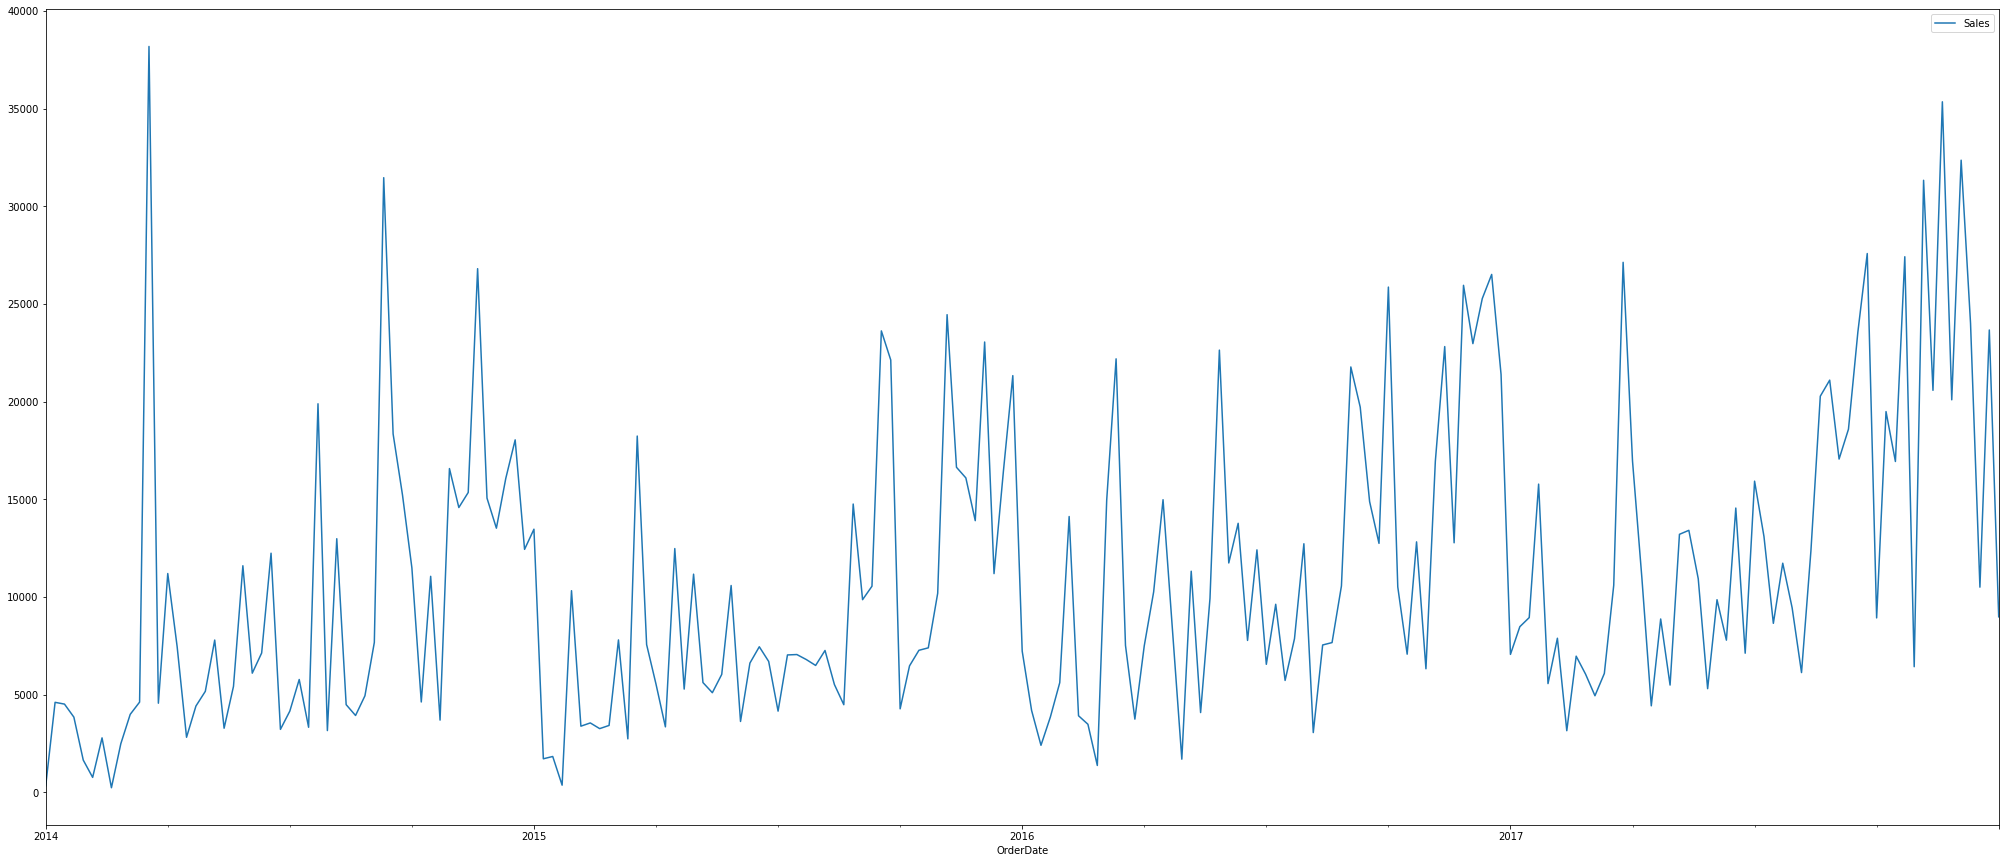

In [51]:
plt.figure(figsize=(35,35))
sales_df.plot(figsize =(35,15) )

<AxesSubplot:xlabel='OrderDate'>

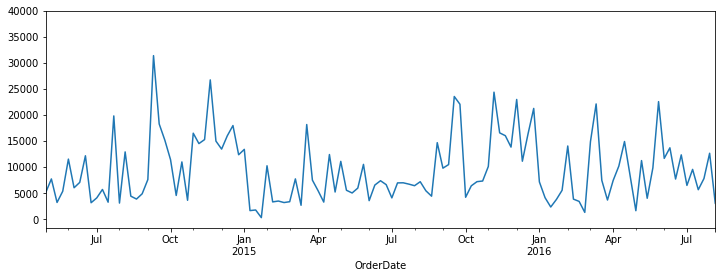

In [52]:
sales_df['Sales'].plot(xlim=['2014-05-01','2016-08-03'],figsize=(12,4))

In [53]:
from statsmodels.tsa.stattools import adfuller

result=adfuller(sales_df['Sales'])
result[1]

1.9502989277502882e-07

# Model building 

## Auto Regressive Model

In [12]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

C:\Users\HP\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


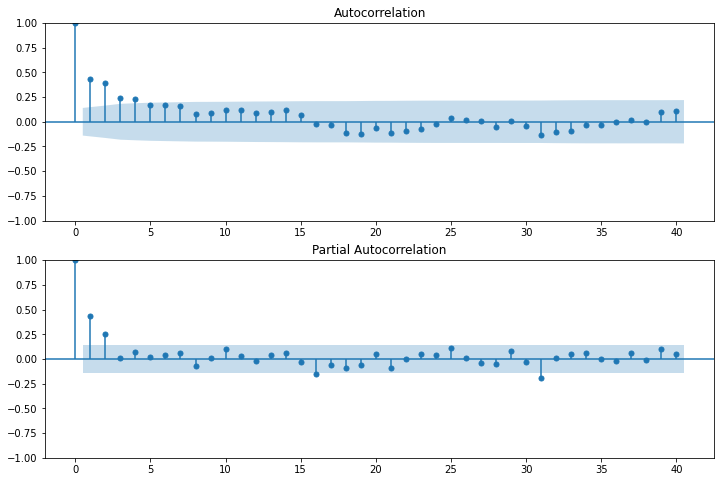

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sales_df['Sales'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sales_df['Sales'].iloc[13:],lags=40,ax=ax2)

## Arima

In [152]:
plt.rc('font', size=10)
plt.rc('axes', titlesize=10)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.rc('figure', titlesize=20)

In [58]:
import statsmodels.api as sm

In [54]:
from datetime import datetime,timedelta
train_dataset_end=datetime(2017,4,1)

train_data=sales_df[:train_dataset_end]
test_data=sales_df[train_dataset_end+timedelta(days=1):]

In [55]:
train_data.shape,test_data.shape

((169, 1), (40, 1))

<AxesSubplot:xlabel='OrderDate'>

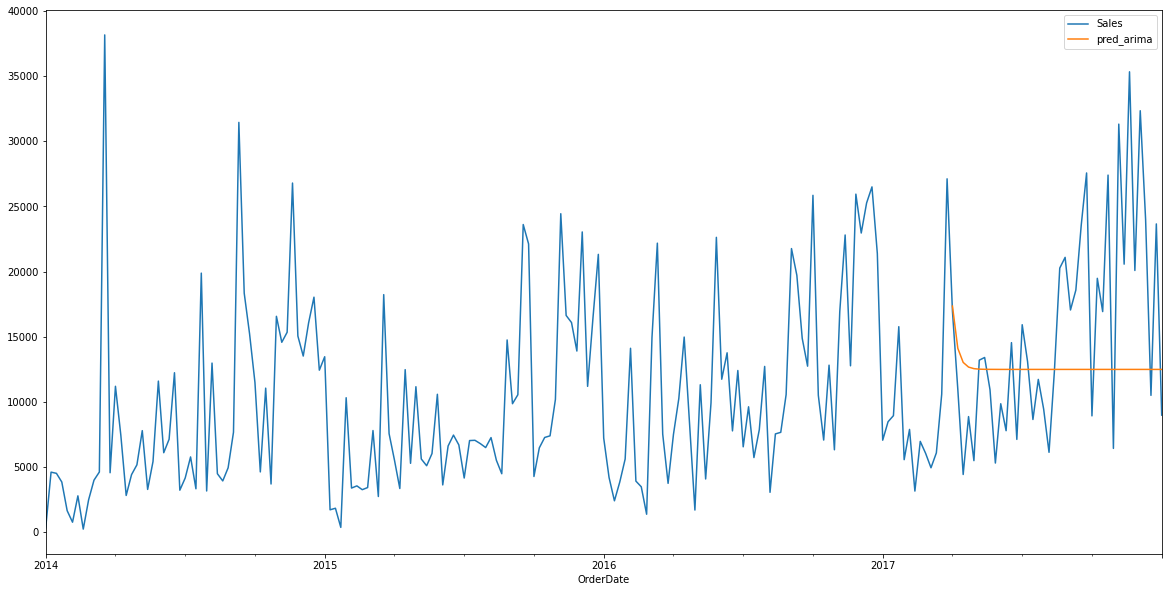

In [100]:
from statsmodels.tsa.arima.model import ARIMA

model_ARIMA=ARIMA(train_data['Sales'],order=(1, 1, 1))
model_Arima_fit=model_ARIMA.fit()
model_Arima_fit.summary()

pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
sales_df['pred_arima']=model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)
sales_df[['Sales','pred_arima']].plot(figsize =(20,10))

### Tuning ARIMA

In [ ]:
from sklearn.metrics import mean_squared_error

p_values = [0, 1]
d_values = range(0, )
q_values = range(0, 20)

df_order = pd.DataFrame(columns=['order','MSE'])
i = 0
for p in p_values:
    for d in d_values:
        for q in q_values: 
            order = (p,d,q)
            warnings.filterwarnings("ignore")
            model = ARIMA(train_data['Sales'], order=order).fit()
            predictions = model.predict(start=pred_start_date,end=pred_end_date)
            error = mean_squared_error(test_data, predictions)
            row = [order,error]
            i = i+1
            df_order.loc[i] = row
            
            

In [226]:
df_order.MSE.min()
df_order[df_order.MSE == df_order.MSE.min()]

,order,MSE
74,"(0, 3, 13)",5.200083e+07


<AxesSubplot:xlabel='OrderDate'>

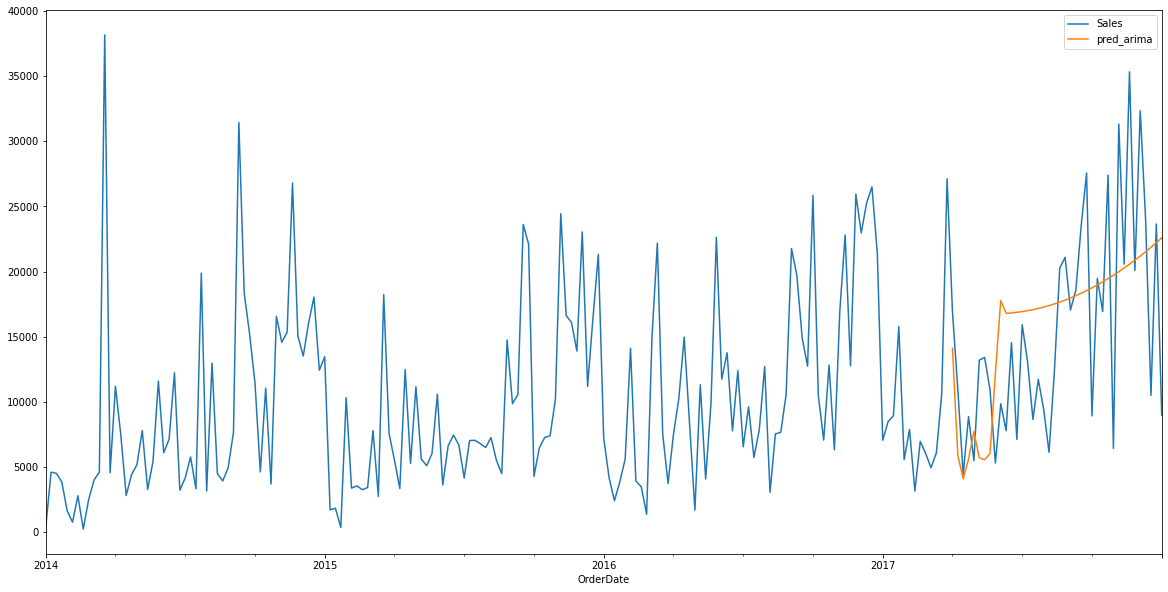

In [101]:
from statsmodels.tsa.arima.model import ARIMA

model_ARIMA=ARIMA(train_data['Sales'],order=(0, 3, 13))
model_Arima_fit=model_ARIMA.fit()
model_Arima_fit.summary()

sales_df['pred_arima']=model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)
sales_df[['Sales','pred_arima']].plot(figsize =(20,10))

## Sarima

In [ ]:
from sklearn.metrics import mean_squared_error

p_values = [0, 1]
d_values = [i for i in range(10) if i%3==1]
q_values = [i for i in range(10) if i%3==1]

a_values = [i for i in range(10) if i%3==1]
b_values = [i for i in range(10) if i%3==1]
c_values = [i for i in range(10) if i%3==1]
m_values = [i for i in range(2,15) if i%3==1]

df_order = pd.DataFrame(columns=['order','seasonal_order','MSE'])
i = 0
for p in p_values:
    for d in d_values:
        for q in q_values:
            for a in a_values:
                for b in b_values:
                    for c in c_values:
                        for m in m_values:
                            if m>q:
                                order = (p,d,q)
                                seasonal_order = (a,b,c,m)
                                warnings.filterwarnings("ignore")
                                model=sm.tsa.statespace.SARIMAX(train_data['Sales'],order=order,seasonal_order=seasonal_order).fit()
                                predictions = model.predict(start=pred_start_date,end=pred_end_date)
                                error = mean_squared_error(test_data, predictions)
                                row = [order,seasonal_order,error]
                                i = i+1
                                df_order.loc[i] = row


In [264]:
df_order[df_order.MSE == df_order.MSE.min()]

,order,seasonal_order,MSE
1,"(0, 1, 1)","(1, 1, 1, 4)",5.941346e+07


In [89]:
model_sarimax=sm.tsa.statespace.SARIMAX(train_data['Sales'],order=(0, 1, 3),seasonal_order=(1,1,1,36))
results=model_sarimax.fit()

<AxesSubplot:xlabel='OrderDate'>

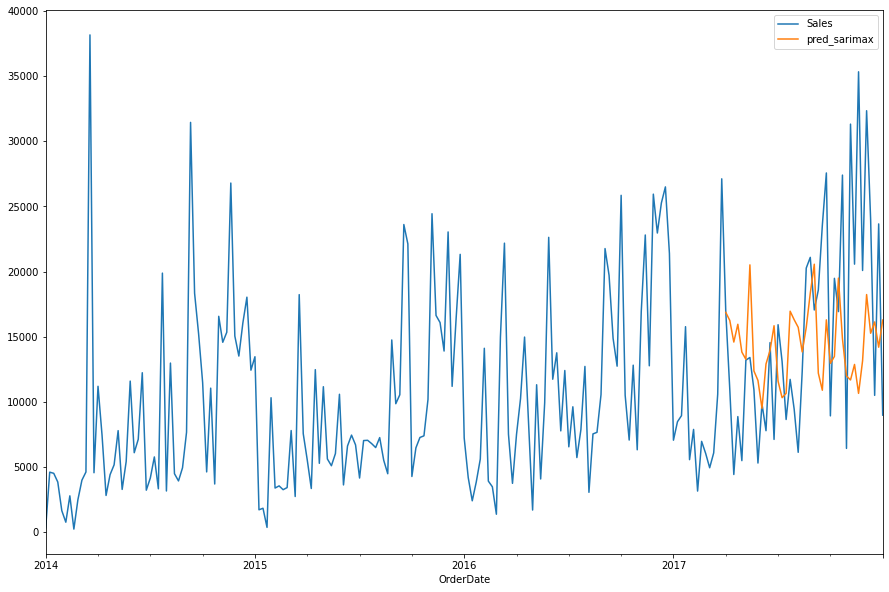

In [102]:
sales_df['pred_sarimax']=results.predict(start=pred_start_date,end=pred_end_date)
sales_df[['Sales','pred_sarimax']].plot(figsize =(15,10))

## LSTM

In [30]:
from datetime import datetime,timedelta
train_dataset_end=datetime(2017,4,1)

train_data=sales_df[:train_dataset_end]
test_data=sales_df[train_dataset_end+timedelta(days=1):]

In [32]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [146]:
n_input = 30
n_features = 1
generator = TimeseriesGenerator(train_data['Sales'], train_data['Sales'], length=n_input, batch_size=1)

In [147]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM

In [150]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features),return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [151]:
model.fit(generator,epochs=100)

Epoch 1/100
139/139 [==============================] - 11s 40ms/step - loss: 169995872.0000
Epoch 2/100
139/139 [==============================] - 6s 41ms/step - loss: 303283008.0000
Epoch 3/100
139/139 [==============================] - 6s 42ms/step - loss: 287543744.0000
Epoch 4/100
139/139 [==============================] - 6s 42ms/step - loss: 725292992.0000
Epoch 5/100
139/139 [==============================] - 6s 40ms/step - loss: 627167168.0000
Epoch 6/100
139/139 [==============================] - 6s 40ms/step - loss: 1044493760.0000
Epoch 7/100
139/139 [==============================] - 6s 43ms/step - loss: 221751664.0000
Epoch 8/100
139/139 [==============================] - 6s 41ms/step - loss: 250979104.0000
Epoch 9/100
139/139 [==============================] - 6s 43ms/step - loss: 115452664.0000
Epoch 10/100
139/139 [==============================] - 6s 46ms/step - loss: 277055168.0000
Epoch 11/100
139/139 [==============================] - 6s 43ms/step - loss: 73962680.0

139/139 [==============================] - 6s 43ms/step - loss: 60603328.0000
Epoch 91/100
139/139 [==============================] - 6s 43ms/step - loss: 59505044.0000
Epoch 92/100
139/139 [==============================] - 6s 41ms/step - loss: 64107676.0000
Epoch 93/100
139/139 [==============================] - 6s 41ms/step - loss: 59335424.0000
Epoch 94/100
139/139 [==============================] - 6s 41ms/step - loss: 57709232.0000
Epoch 95/100
139/139 [==============================] - 6s 41ms/step - loss: 57830572.0000
Epoch 96/100
139/139 [==============================] - 6s 41ms/step - loss: 63045344.0000
Epoch 97/100
139/139 [==============================] - 6s 42ms/step - loss: 56044044.0000
Epoch 98/100
139/139 [==============================] - 6s 42ms/step - loss: 58118604.0000
Epoch 99/100
139/139 [==============================] - 6s 44ms/step - loss: 58117640.0000
Epoch 100/100
139/139 [==============================] - 6s 45ms/step - loss: 66609004.0000


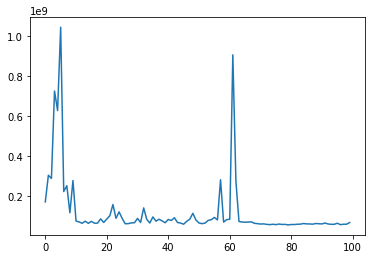

In [153]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [154]:
test_predictions = []

first_eval_batch = np.array(test_data['Sales'][-n_input:])
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [155]:
test_predictions = np.array(test_predictions)

In [156]:
test_data['LSTM_Predictions'] = test_predictions
test_data.head()

,Sales,LSTM_Predictions,pred_sarimax,pred_arima
OrderDate,,,,
2017-04-02,16952.9938,9955.604492,16871.026935,14123.638281
2017-04-09,10955.3485,10378.822266,16249.627051,5889.370038
2017-04-16,4420.5160,10108.416016,14590.830533,4083.428674
2017-04-23,8866.1770,11440.980469,15955.182760,5603.031300
2017-04-30,5483.5366,11625.538086,13819.978412,7723.251391


<AxesSubplot:xlabel='OrderDate'>

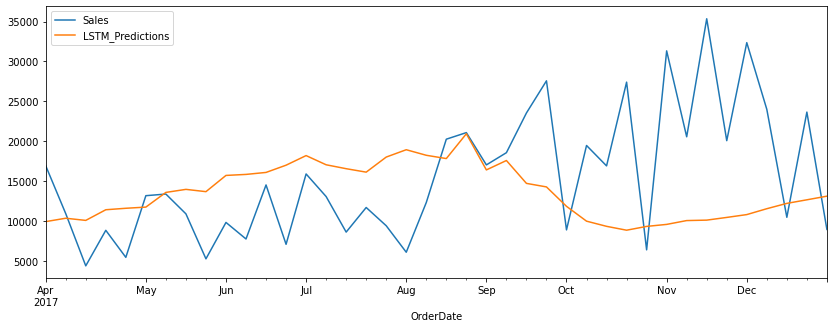

In [157]:
test_data[['Sales','LSTM_Predictions']].plot(figsize=(14,5))

## Overall

<AxesSubplot:xlabel='OrderDate'>

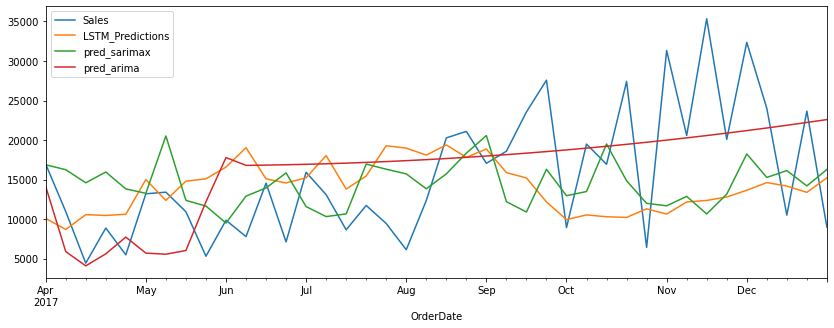

In [136]:
test_data['pred_sarimax']=results.predict(start=pred_start_date,end=pred_end_date)
test_data['pred_arima']=model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)
test_data.plot(figsize=(14,5))